# TensorFlow Detalhado

No último tutorial, mostrei o essencial para montar uma rede neural no TensorFlow. Aqui, vamos entrar em alguns detalhes que podem ajudar a tornar o código mais organizado e fácil de entender. Vamos considerar como exemplo rede neural para classificar imagens de dígitos escritos a mão. As imagens pertencem a 10 classes, do dígito 0 ao 9. Os dados são imagens de 28 por 28 pixeis, o que nos dá 784 variáveis. Nos tutoriais passados, nossos alvos eram vetores *one-hot*. Agora, eles serão simples variáveis categóricas, com a categoria 0 representando o dígito zero,  a categoria 1 representando o dígito 1 e assim por diante.

Extracting tmp/train-images-idx3-ubyte.gz
Extracting tmp/train-labels-idx1-ubyte.gz
Extracting tmp/t10k-images-idx3-ubyte.gz
Extracting tmp/t10k-labels-idx1-ubyte.gz


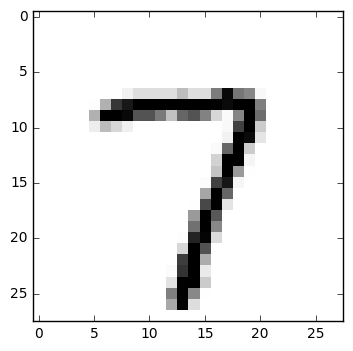

In [1]:
import numpy as np
import os # para criar pastas
from matplotlib import pyplot as plt
import tensorflow as tf

# criamos uma pasta para salvar o modelo
if not os.path.exists('tmp'): # se a pasta não existir
    os.makedirs('tmp') # cria a pasta

# baixa os dados em na pasta criada e carrega os dados 
from tensorflow.examples.tutorials.mnist import input_data
data = input_data.read_data_sets("tmp/", one_hot=False) # repare que não usamos vetores one-hot

# mostra uma imagem
plt.imshow(data.train.images[100].reshape(28,28), cmap='Greys', interpolation='nearest')
plt.show()

## Escopos de Nomes

No TensorFlow, quando um nó é adicionada ao grafo, isso é feito sob um escopo. Nós podemos pensar nisso como o **nome que atribuímos ao nó dentro do grafo**. Esse nome não é necessariamente o mesmo que damos à variável no Python. Por exemplo, no grafo abaixo, definimos um nó com uma constante e atribuímos a ela o nome nome `b`, tanto no Python como no grafo TensorFlow. Podemos usar `print()` na variável definida em Python para confirmar o nome dela no grafo TensorFlow. Em seguida, nós redefinimos a constante `b` no Python, passando um novo nó com uma nova constante a ela. Também damos a esse nó o  nome `b`, no TensorFlow. No entanto, quando usamos `print()` para confirmar o nome desse nó, não é `b` que aparece, mas `b_0`. Por que isso acontece?

In [2]:
graph = tf.Graph()
with graph.as_default():
    # criamos constante com valor 8
    b = tf.constant(8, name='b')
    print(b)
    
    # criamos constante com valor 0
    b = tf.constant(0, name='b')
    print(b)

Tensor("b:0", shape=(), dtype=int32)
Tensor("b_1:0", shape=(), dtype=int32)


Mesmo que tenhamos redefinido a variável `b`, cada vez que atribuímos um nó TensorFlow a uma variável no Python, **adicionamos este nó ao grafo TensorFlow**. Ou seja, no Python, houve uma redefinição com sobrescrição de `b`, mas no TensorFlow ambos os nós continuam existindo e **não há sobrescrição**. Em vez disso, adiciona-se `_1` a frente de `b`  para evitar a sobrescrição. 

Agora que sabemos como os nomes das variáveis se comportam dentro do grafo TensorFlow, estamos prontos para aprender sobre os escopos dos nomes. Em poucas palavras, os escopos servem para organizar o nosso código TensorFlow (e para melhorar a visualização com o TensorBoard, como veremos mais para frente). Como recomendação de organização, devemos agrupar nós similares em um escopo próprio. Agora, não há uma definição clara do que seja essa similaridade. Na verdade, ela é muito variável e difere de modelo para modelo. Por exemplo, suponha que tenhamos uma rede neural com 3 camadas. Cada camada terá suas variáveis `W` e `b`, além das operações de multiplicação de matriz e não linearidade. Então, em vez de ficar criando nomes para cada um desses nós, nós podemos agrupá-los sob um escopo da camada e dar o mesmo nome para todos eles. Vejamos como isso é feito.

In [3]:
# definindo constantes 
lr = 0.01 # taxa de aprendizado
n_iter = 1000 # número de iterações de treino
batch_size = 128 # qtd de imagens no mini-lote (para GDE)
n_inputs = 28 * 28 # número de variáveis (pixeis)
n_l1 = 512 # número de neurônios da primeira camada
n_l2 = 512 # número de neurônios da segunda camada
n_outputs = 10 # número classes (dígitos)

graph = tf.Graph() # cria um grafo
with graph.as_default(): # abre o grafo para que possamos colocar nós
    
    # Camadas de Inputs
    with tf.name_scope('input_layer'): # escopo de nome da camada de entrada
        x_input = tf.placeholder(tf.float32, [None, n_inputs], name='images')
        y_input = tf.placeholder(tf.int64, [None], name='labels')

    # Camada 1
    with tf.name_scope('first_layer'): # escopo de nome da primeira camada
        # variáveis da camada
        W1 = tf.Variable(tf.truncated_normal([n_inputs, n_l1]), name='Weights')
        b1 = tf.Variable(tf.zeros([n_l1]), name='bias')

        l1 = tf.add(tf.matmul(x_input, W1), b1, name='linear_transformation')
        l1 = tf.nn.relu(l1, name='relu')
    
    # Camada 2 
    with tf.name_scope('second_layer'): # escopo de nome da segunda camada
        # variáveis da camada
        W2 = tf.Variable(tf.truncated_normal([n_l1, n_l2]), name='Weights')
        b2 = tf.Variable(tf.zeros([n_l2]), name='bias')

        l2 = tf.add(tf.matmul(l1, W2), b2, name='linear_transformation')
        l2 = tf.nn.relu(l2, name='relu')
    
    # Camada de saída
    with tf.name_scope('output_layer'): # escopo de nome da camada de saída
        # variáveis da camada
        Wo = tf.Variable(tf.truncated_normal([n_l2, n_outputs]), name='Weights')
        bo = tf.Variable(tf.zeros([n_outputs]), name='bias')
        
        scores = tf.add(tf.matmul(l2, Wo), bo, name='linear_transformation') # logits
        error = tf.reduce_mean(
            tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y_input, logits=scores),
            name='error')
        
    # calcula acurácia
    correct = tf.nn.in_top_k(scores, y_input, 1) # calcula obs corretas (vetor bools V ou F)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32)) # converte de bool para float32
        
    # otimizador
    optimizer = tf.train.AdamOptimizer(learning_rate=lr).minimize(error)

    # inicializador
    init = tf.global_variables_initializer()

    # para salvar o modelo treinado
    saver = tf.train.Saver()
    
    # conferindo os nomes
    print(y_input)
    print(scores)
    print(W1)
    print(b1)
    print(W2)

Tensor("input_layer/labels:0", shape=(?,), dtype=int64)
Tensor("output_layer/linear_transformation:0", shape=(?, 10), dtype=float32)
<tf.Variable 'first_layer/Weights:0' shape=(784, 512) dtype=float32_ref>
<tf.Variable 'first_layer/bias:0' shape=(512,) dtype=float32_ref>
<tf.Variable 'second_layer/Weights:0' shape=(512, 512) dtype=float32_ref>


Acima, agrupamos nosso modelo de rede neural em 4 camadas: uma de entrada, duas camadas ocultas de neurônios com ativação `ReLU` e uma camada de saída. Note como mudamos a estrutura de construção do grafo, relativa a que ensinei no [tutorial passado](https://matheusfacure.github.io/2017/05/12/tensorflow-essencial/). Lá, eu disse para começarmos definindo as variáveis de todas as camadas e só então montar o modelo. Aqui, definimos as variáveis junto com a montagem do modelo. Não há uma regra geral sobre qual forma de estruturar um programa TensorFlow é melhor. Eu costumo usar estrutura do tutorial passado na maioria dos casos (com definição de variáveis separada da montagem do modelo). No entanto, a forma acima faz mais sentido quando estamos organizando o código em escopos de nomes, o que geralmente é melhor com modelos muito grandes e complicados.

Vamos agora, por partes, explicar o que fizemos acima. Como sempre, primeiro definimos algumas constantes, que serão os hiper-parâmetros do nosso modelo. Depois, passamos à fase de construção do grafo, começando com a montagem do modelo, o que fazemos por camadas. Abrimos um escopo para a camada de *inputs* com `with tf.name_scope():` e colocamos os nós de * inputs* - os *placeholders* - dentro desse escopo. Em seguida, abrimos o escopo da primeira camada oculta. Dentro dele, primeiro adicionamos as variáveis dessa camada e depois realizamos uma transformação linear, seguida de uma `ReLU`.  Criamos então a segunda camada oculta de forma idêntica à criação da primeira. Por fim, abrimos um escopo para a camada de saída. Nele, criamos nós para as variáveis da camada, para os *logits*, para a probabilidade prevista (`y_hat`) e para o erro. Note que a nossa camada de *output* retorna *logits* que são vetores de tamanho 10, com casa espaço representando a probabilidade prevista do dígito correspondente. No entanto, nossos alvos são variáveis categóricas no formato de um escalar, isto é, um único número. Por conta disso, usamos como custo a função com esse nome gigante `sparse_softmax_cross_entropy_with_logits()`. Ela faz três coisas: (1) converte os alvos de variáveis categóricas para vetores *one-hot*; (2) aplica a transformação softmax, que converte os *logits* em probabilidades (valores entre 0 e 1, somando 1); (3) calcula o custo de entropia cruzada.  

Terminada a construção do nosso modelo, adicionamos nós para calcular a acurácia,  um nó com o otimizador para treinar o modelo, um nó para iniciar as variáveis e um nó para salvar o modelo treinado. Por fim, usamos `print()` para verificar o nome das variáveis no grafo TensorFlow. Note como o nome do escopo é adicionado antes do nome do nó. Vamos agora para a fase de execução desse grafo. Note como ela é extremamente similar a que fizemos no tutorial passado. A única diferença é a forma como a acurácia é calculada.

In [4]:
# abrimos a sessão tf
with tf.Session(graph=graph) as sess:
    init.run() # iniciamos as variáveis
    
    # loop de treinamento
    for step in range(n_iter+1):

        # cria os mini-lotes
        x_batch, y_batch = data.train.next_batch(batch_size)

        # cria um feed_dict
        feed_dict = {x_input: x_batch, y_input: y_batch}

        # executa uma iteração de treino e calcula o erro
        l, _ = sess.run([error, optimizer], feed_dict=feed_dict)
            
        # mostra o progresso a cada 1000 iterações
        if step % 1000 == 0:
            
            x_valid, y_valid = data.validation.next_batch(512) # pega alguns dados de validação
            val_dict = {x_input: x_valid, y_input: y_valid} # monta o feed_dict
            
            # executa o nó para calcular a acurácia
            error_np, acc = sess.run([error, accuracy], feed_dict=val_dict) 
            
            print('Erro de treino na iteração %d: %.2f' % (step, l))
            print('Erro de validação na iteração %d: %.2f' % (step, error_np))
            print('Acurácia de validação na iteração %d: %.2f\n' % (step, acc))

            # salva as variáveis do modelo
            saver.save(sess, "./tmp/deep_ann.ckpt")

Erro de treino na iteração 0: 1924.37
Erro de validação na iteração 0: 1437.47
Acurácia de validação na iteração 0: 0.21

Erro de treino na iteração 1000: 6.81
Erro de validação na iteração 1000: 8.84
Acurácia de validação na iteração 1000: 0.96



## Factoring out

Você deve ter reparado que o código acima é bastante repetitivo. Seria bom se pudéssemos usar um pouco de modularidade, colocando algumas partes da construção do grafo em funções. Isso pode ser feito facilmente e torna o código muito mais fácil de manter e menos suscetível a error de copia e cola. Abaixo, nós criamos uma função que adiciona ao grafo as variáveis de uma camada de neurônios da rede neural. Ela aceita como argumento uma matriz de variáveis, que pode ser tanto a camada de *inputs* na nossa rede neural quanto os *outputs* de uma camada intermediária (lembre-se que uma camada da rede neural trata os *outputs* da camada anterior exatamente como a primeira camada trata os dados originais; afinal, o que a rede neural faz é aprender variáveis representativas ao longo das camadas). Em seguida, na função, descobrimos o formato dessa matriz de *input* com `inputs.get_shape()`. Nós pegamos o número de colunas da matriz de *inputs*, ou seja, o número de variáveis, e com isso mais o número de neurônios da camada, passado como argumento `n_neurons`, criamos as variáveis `W` e `b` da camada em questão. Por fim, nós realizamos a tranformação linear da camada e aplicamos a não linearidade, caso a função de ativação seja passada como argumento. 

O resto do código reimplementa o mesmo gráfico que vimos acima, mas agora usando essa função para criar as camadas.

In [5]:
def fully_conected_layer(inputs, n_neurons, name_scope, activations=None):
    '''Adiciona os nós de uma camada ao grafo TensorFlow'''
    with tf.name_scope(name_scope):
        
        # define as variáveis da camada
        n_inputs = int(inputs.get_shape()[1]) # pega o formato dos inputs
        W = tf.Variable(tf.truncated_normal([n_inputs, n_neurons]), name='Weights')
        b = tf.Variable(tf.zeros([n_neurons]), name='biases')
        
        # operação linar da camada
        layer = tf.add(tf.matmul(inputs, W), b, name='linear_transformation')
        
        # aplica não linearidade, se for o caso
        if activations == 'relu':
            layer = tf.nn.relu(layer, name='relu')
        
        return layer
    

graph = tf.Graph()
with graph.as_default():
    
    # Camadas de Inputs
    with tf.name_scope('input_layer'):
        x_input = tf.placeholder(tf.float32, [None, n_inputs], name='images')
        y_input = tf.placeholder(tf.int64, [None], name='labels')

    # Camada 1
    l1 = fully_conected_layer(x_input, n_neurons=n_l1, name_scope='first_layer', activations='relu')
    
    # Camada 2
    l2 = fully_conected_layer(l1, n_neurons=n_l2, name_scope='second_layer', activations='relu')
        
    # Camada de saída
    scores = fully_conected_layer(l2, n_neurons=n_outputs, name_scope='output_layer') # logits
    error = tf.reduce_mean(
        tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y_input, logits=scores),
        name='error')
    
    # calcula acurácia
    correct = tf.nn.in_top_k(scores, y_input, 1) # calcula obs corretas
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32)) # converta para float32
    
    # otimizador
    optimizer = tf.train.AdamOptimizer(learning_rate=lr).minimize(error)

    # inicializador
    init = tf.global_variables_initializer()

    # para salvar o modelo treinado
    saver = tf.train.Saver()    
        

O que temos que ter em mente, é que a função que criamos **NÃO**  performa nenhuma computação. Ela apenas **adiciona os nós (variáveis e operações) de uma camada ao grafo TensorFlow**. Assim, quando chamamos `l1 = fully_conected_layer(...)` o que de fato fazemos é adicionar as variáveis da camada ao grafo. A execução do grafo construído acima é exatamente mesma dos anteriores.

In [6]:
# abrimos a sessão tf
with tf.Session(graph=graph) as sess:
    init.run() # iniciamos as variáveis
    
    # loop de treinamento
    for step in range(n_iter+1):

        # cria os mini-lotes
        x_batch, y_batch = data.train.next_batch(batch_size)

        # cria um feed_dict
        feed_dict = {x_input: x_batch, y_input: y_batch}

        # executa uma iteração de treino e calcula o erro
        l, _ = sess.run([error, optimizer], feed_dict=feed_dict)
            
        # mostra o progresso a cada 1000 iterações
        if step % 1000 == 0:
            
            x_valid, y_valid = data.validation.next_batch(512) # pega alguns dados de validação
            val_dict = {x_input: x_valid, y_input: y_valid} # monta o feed_dict
            error_np, acc = sess.run([error, accuracy], feed_dict=val_dict) # calcula probabilidades e erro 
            
            print('Erro de treino na iteração %d: %.2f' % (step, l))
            print('Erro de validação na iteração %d: %.2f' % (step, error_np))
            print('Acurácia de validação na iteração %d: %.2f\n' % (step, acc))

            # salva as variáveis do modelo
            saver.save(sess, "./tmp/deep_ann.ckpt")

Erro de treino na iteração 0: 2094.33
Erro de validação na iteração 0: 1727.43
Acurácia de validação na iteração 0: 0.18

Erro de treino na iteração 1000: 14.40
Erro de validação na iteração 1000: 13.60
Acurácia de validação na iteração 1000: 0.95



# Vizualização

Se você já está achando o TensorFlow uma ferramente fenomenal, agora terá certeza disso. Assim que você instala o TensorFlow, junto vem o [TensorBoard](https://www.tensorflow.org/get_started/summaries_and_tensorboard), uma ferramente de vizualização super completa, que permite analisar o grafo criado, resumir estatísticas de erro e ver como os parâmetros evoluem. Em se tratando de redes neurais, ver o grafo pode ser muito útil para entender o fluxo de dados no interior da rede. Além disso, ver como o treinamento evolui é a melhor técnica de *debugging* de redes neurais. Vamos então ver como trabalhar com o TensorBoard. Primeiro reformar nossa função de criar camadas de neurônios.

In [7]:
def fully_conected_layer(inputs, n_neurons, name_scope, activations=None):
    '''Adiciona os nós de uma camada ao grafo TensorFlow'''
    
    n_inputs = int(inputs.get_shape()[1]) # pega o formato dos inputs
    with tf.name_scope(name_scope):
        
        # define as variáveis da camada
        with tf.name_scope('Parameters'):
            W = tf.Variable(tf.truncated_normal([n_inputs, n_neurons]), name='Weights')
            b = tf.Variable(tf.zeros([n_neurons]), name='biases')
            
            tf.summary.histogram('Weights', W) # para registrar o valor dos W
            tf.summary.histogram('biases', b) # para registrar o valor dos b
        
        # operação linar da camada
        layer = tf.add(tf.matmul(inputs, W), b, name='Linear_transformation')
        
        # aplica não linearidade, se for o caso
        if activations == 'relu':
            layer = tf.nn.relu(layer, name='ReLU')
        
        # para registar a ativação na camada
        tf.summary.histogram('activations', layer)
        
        return layer

Repare que as únicas mudanças são adições de *summaries* (ou resumos). Primeiro, usando `tf.summary.histogram()`, criamos um nó para salvar histogramas dos parâmetros da camada. Depois, criamos um nó para registrar um histograma da ativação (*output*) da camada. Vamos agora adicionar mais alguns nós de resumo no resto do grafo. Repare também como colocamos mais operações dentro de `tf.name_scope()`. Isso é feito apenas por motivo estético e tornará a visualização do nosso grafo mais agrupada. Também usamos `tf.summary.scalar()` para resumir a evolução de uma variável representada por um único número (ou seja, um escalar), tais como o erro em termos de entropia cruzada e em termos de acurácia. 

In [8]:
logdir = 'logs' # nome pasta para salvar os arquivos de visualização

graph = tf.Graph()
with graph.as_default():
    
    # Camadas de Inputs
    with tf.name_scope('input_layer'):
        x_input = tf.placeholder(tf.float32, [None, n_inputs], name='images')
        y_input = tf.placeholder(tf.int64, [None], name='labels')

    # Camada 1
    l1 = fully_conected_layer(x_input, n_neurons=n_l1, name_scope='First_layer', activations='relu')
    
    # Camada 2
    l2 = fully_conected_layer(l1, n_neurons=n_l2, name_scope='Second_layer', activations='relu')
        
    # Camada de saída
    scores = fully_conected_layer(l2, n_neurons=n_outputs, name_scope='Output_layer') # logits
    
    # camada de erro
    with tf.name_scope('Error_layer'):
        error = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y_input, logits=scores),
                               name='error')
        tf.summary.scalar('Cross_entropy', error) # para registrar a função custo
    
    with tf.name_scope("Accuracy"):
        correct = tf.nn.in_top_k(scores, y_input, 1) # calcula obs corretas
        accuracy = tf.reduce_mean(tf.cast(correct, tf.float32)) # converta para float32
        tf.summary.scalar('Accuracy', accuracy) # para registrar a função custo
        
    # otimizador
    with tf.name_scope('Train_operation'):
        optimizer = tf.train.AdamOptimizer(learning_rate=lr).minimize(error)
        
    # inicializador
    init = tf.global_variables_initializer()

    # para salvar o modelo treinado
    saver = tf.train.Saver()
    
    # para registrar na visualização
    summaries = tf.summary.merge_all() # funde todos os summaries em uma operação
    file_writer = tf.summary.FileWriter(logdir, tf.get_default_graph()) # para escrever arquivos summaries
        

Para que não tenhamos que rodar todos os resumos individualmente na fase de execução do grafo, usamos `tf.summary.merge_all()` para fundir todos os nós de resumo em um só. Na fase de execução então, adicionamos o nó `summaries` às operações para serem executadas durante uma iteração de treino. Quando esse nó é executado, ele retorna uma *string* (texto) codificando a informação dos resumos naquela iteração de treino. Repare que como executamos os resumos durante o treino, a acurácia que será armazenada pelo TensorBoard será a de treino, referente ao mini-lote daquela iteração. Por fim, ainda na fase de construção, com `tf.summary.FileWriter()` criamos um nó que se encarregará de escrever a informação dos resumos no disco. Para a construção desse nó, passamos o nome de uma pasta (diretório) e passamos também o grafo que será salvo para visualização (nesse caso, o grafo que estamos construindo, que é acessado com `tf.get_default_graph()`).

A cada 10 iterações, vamos escrever no disco a *string* de informações dos resumos. Fazemos isso com o método `file_writer.add_summary()` do nó que criamos antes para salvar informação no disco. Escrever no disco é uma operação demorada, principalmente se seu disco rígido for um HD e não um SSD. Isso significa que usar o TensorBoard aumenta drasticamente o tempo de treinamento de uma rede neural, devendo então ser utilizado apenas quando o objetivo é a visualização em si ou *debugging*.

In [9]:
# abrimos a sessão tf
with tf.Session(graph=graph) as sess:
    init.run() # iniciamos as variáveis
    
    # loop de treinamento
    for step in range(n_iter+1):

        # cria os mini-lotes
        x_batch, y_batch = data.train.next_batch(batch_size)

        # cria um feed_dict
        feed_dict = {x_input: x_batch, y_input: y_batch}

        # executa uma iteração de treino e calcula o erro
        l, summaries_str, _ = sess.run([error, summaries, optimizer], feed_dict=feed_dict)
        
        # a cada 10 iterações, salva os registros dos summaries
        if step % 10 == 0:
            file_writer.add_summary(summaries_str, step)
        
        # mostra o progresso a cada 1000 iterações
        if step % 200 == 0:
            
            x_valid, y_valid = data.validation.next_batch(512) # pega alguns dados de validação
            val_dict = {x_input: x_valid, y_input: y_valid} # monta o feed_dict
            error_np, acc = sess.run([error, accuracy], feed_dict=val_dict) # calcula probabilidades e erro 
            
            print('Erro de treino na iteração %d: %.2f' % (step, l))
            print('Erro de validação na iteração %d: %.2f' % (step, error_np))
            print('Acurácia de validação na iteração %d: %.2f\n' % (step, acc))

            # salva as variáveis do modelo
            saver.save(sess, "./tmp/deep_ann.ckpt")

file_writer.close()

Erro de treino na iteração 0: 2471.73
Erro de validação na iteração 0: 1733.50
Acurácia de validação na iteração 0: 0.19

Erro de treino na iteração 200: 39.70
Erro de validação na iteração 200: 38.54
Acurácia de validação na iteração 200: 0.92

Erro de treino na iteração 400: 35.02
Erro de validação na iteração 400: 23.41
Acurácia de validação na iteração 400: 0.94

Erro de treino na iteração 600: 5.25
Erro de validação na iteração 600: 14.61
Acurácia de validação na iteração 600: 0.95

Erro de treino na iteração 800: 20.52
Erro de validação na iteração 800: 9.58
Acurácia de validação na iteração 800: 0.96

Erro de treino na iteração 1000: 7.65
Erro de validação na iteração 1000: 16.07
Acurácia de validação na iteração 1000: 0.95



Agora, na pasta onde você rodou esse código, deve haver uma pasta com o nome `logs`. Na linha de comando digite

```bash
$ tensorboard --logdir logs/
```

Isso inicializará o TensorBoard. Vá em um Browser (Chrome ou Firefox) e navegue para http://localhost:6006 para proceder com a visualização.